In [1]:
import torch  
import torchvision
from torchvision import transforms
import numpy as np  
import random  
from matplotlib import pyplot as plt  
import os  
import shutil
import torch.nn as nn 
import time  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 启用CUDA加速

In [2]:
def draw(acc1, acc2, loss1, loss2):
    x = range(len(acc1))
    # 创建一个1行2列的图像布局
    plt.figure(figsize=(8, 3))
    # 画图函数
    plt.subplot(1, 2, 1)
    plt.plot(x, acc1, label="train")
    plt.plot(x, acc2, color='r', label="test")
    plt.xlabel("epoch")
    plt.ylabel("acc")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss1, label="train")
    plt.plot(x, loss2, color='r', label="test")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [3]:
def reset(folders):
    for folder in folders:
        for filename in os.listdir(folder):
            filepath = os.path.join(folder, filename)
            if os.path.isfile(filepath) or os.path.islink(filepath):
                os.unlink(filepath)
            elif os.path.isdir(filepath):
                shutil.rmtree(filepath)

# 重置训练集和测试集
folders = ['./cardata/train/car', 
           './cardata/train/bus', 
           './cardata/train/truck',
           './cardata/test/car', 
           './cardata/test/bus', 
           './cardata/test/truck']

# 划分数据集函数
def makedata():
    random.seed(0)
    datapath = os.path.join(os.getcwd(), "cardata")
    traindata = os.path.join(datapath, "train")
    testdata = os.path.join(datapath, "test")
    types = ['car', 'bus', 'truck']
    for t in types:
        tpath = os.path.join(datapath, t)
        images = os.listdir(tpath)
        num = len(images)
        testimg = random.sample(images, k=int(num * 0.25)) # 25%做测试集
        for _, img in enumerate(images):
            if img in testimg:
                # 制作测试集
                imgpath = os.path.join(tpath, img)
                topath = os.path.join(testdata, t)
                shutil.copy(imgpath, topath)
            else:
                # 制作训练集
                imgpath = os.path.join(tpath, img)
                topath = os.path.join(traindata, t)
                shutil.copy(imgpath, topath)

In [4]:
reset(folders)
makedata()
data_transform = {"train": transforms.Compose([transforms.Resize((64 ,64)), # 拉伸到统一大小
                            transforms.RandomHorizontalFlip(),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))]),
                  "test": transforms.Compose([transforms.Resize((64, 64)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])}

batch_size = 1024
train_dataset = torchvision.datasets.ImageFolder(root = os.path.join(os.getcwd(), "cardata/train"), transform = data_transform["train"])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle = True, num_workers = 8)
test_dataset = torchvision.datasets.ImageFolder(root = os.path.join(os.getcwd(), "cardata/test"), transform = data_transform["test"])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False, num_workers = 8)

In [5]:
# 单通道卷积
def corr2d(X,K):
    batch_size,H,W = X.shape
    k_h,k_w = K.shape
    # 初始化结果矩阵
    Y = torch.zeros((batch_size, H - k_h + 1, W - k_w + 1)).to(device)
    for i in range(Y.shape[1]):  
        for j in range(Y.shape [2]):  
            Y[:, i, j] = (X[:, i: i + k_h, j: j + k_w] *  K).sum()  
    return Y

# 多通道卷积
def corr2d_multi_in(X,K):
    res = corr2d(X[:, 0, :, :], K[0, :, :])  
    for i in range(1, X.shape[1]):  
        # 按通道相加  
        res += corr2d(X[:, i, :, :], K[i, :, :])  
    return res

# 多输入/输出通道卷积
def corr2d_multi_in_out(X, K):  
    return torch.stack([corr2d_multi_in(X, k) for k in K],dim=1) 

In [6]:
class MyConv2D(nn.Module):  
    def __init__(self,in_channels, out_channels,kernel_size):  
        super(MyConv2D,self).__init__()  
        # 初始化卷积层的2个参数:卷积核、偏差
        if isinstance(kernel_size,int):  
            kernel_size = (kernel_size,kernel_size)  
            self.weight = nn.Parameter(torch.randn((out_channels, in_channels) + kernel_size)).to(device)  
            self.bias = nn.Parameter(torch.randn(out_channels, 1, 1)).to(device)  
    def forward(self,x):    
        # x:输入图片，维度(batch_size,C_in,H,W) 
        return corr2d_multi_in_out(x, self.weight) + self.bias

In [7]:
# 手动实现
class MyConvModule(nn.Module):  
    def __init__(self):  
        super(MyConvModule,self).__init__()  
        # 定义一层卷积层  
        self.conv = nn.Sequential(  
            MyConv2D(in_channels = 3,out_channels = 32,kernel_size = 3),  
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True))  
        # 输出层,将通道数变为分类数量  
        self.fc = nn.Linear(32, 3)  

    def forward(self,x):  
        # 图片经过一层卷积，输出维度变为(batch_size,C_out,H,W)  
        out = self.conv(x)  
        # 使用平均池化层将图片的大小变为1x1
        out = nn.functional.avg_pool2d(out,62)  
        # 将张量out从shape batchx32x1x1 变为 batch x32  
        out = out.squeeze()  
        # 输入到全连接层将输出的维度变为3  
        out = self.fc(out)  
        return out

In [8]:
# 定义训练和测试函数
def trainmodel(net, traindata):  
    net.train() # 训练模式  
    train_batch_num = len(traindata)
    total_1oss = 0   
    correct = 0 
    sample_num = 0
    # 遍历batch进行训练  
    for i,(data, target) in enumerate (traindata): 
        data = data.to(device).float()  
        target = target.to(device).long()  
        optimizer.zero_grad()  
        output = net(data)  
        loss = criterion(output, target.squeeze())  
        loss.backward()  
        optimizer.step()  
        total_1oss += loss.item( )  
        # 预测类别，选择最大概率的
        prediction = torch.argmax(output, 1)  
        # 计算正确的数量  
        correct += (prediction == target).sum().item()    
        sample_num += len(prediction)
    # 计算loss和acc  
    loss = total_1oss / train_batch_num  
    acc = correct / sample_num  
    return loss, acc  

def testmodel(net, testdata):  
    net.eval() # 测试模式
    test_batch_num = len(testdata)  
    total_loss = 0  
    correct = 0  
    sample_num = 0  
    # 关闭梯度变化  
    with torch.no_grad():  
        for _,(data, target) in enumerate(testdata):  
            data = data.to(device).float()  
            target = target.to(device).long()   
            output = net(data)  
            loss = criterion(output, target)  
            total_loss += loss.item( )  
            prediction = torch.argmax(output, 1)  
            correct += (prediction == target).sum().item()  
            sample_num += len(prediction)  
    loss = total_loss / test_batch_num  
    acc = correct / sample_num  
    return loss,acc

Epoch 1: train: loss 1.136062 acc 0.264966; test: loss 1.024327, acc 0.573964
Epoch 2: train: loss 1.062574 acc 0.264966; test: loss 1.000576, acc 0.573964
Epoch 3: train: loss 1.010221 acc 0.574092; test: loss 0.990549, acc 0.573964
Epoch 4: train: loss 0.979072 acc 0.574092; test: loss 0.984133, acc 0.573964
Epoch 5: train: loss 0.966912 acc 0.574092; test: loss 0.979325, acc 0.573964
Epoch 6: train: loss 0.968738 acc 0.574092; test: loss 0.975775, acc 0.573964
Epoch 7: train: loss 0.977614 acc 0.574092; test: loss 0.973336, acc 0.573964
Epoch 8: train: loss 0.986957 acc 0.574092; test: loss 0.971904, acc 0.573964
Epoch 9: train: loss 0.992712 acc 0.574092; test: loss 0.971398, acc 0.573964
Epoch 10: train: loss 0.993733 acc 0.574092; test: loss 0.971802, acc 0.573964
Spend time: 2031.670


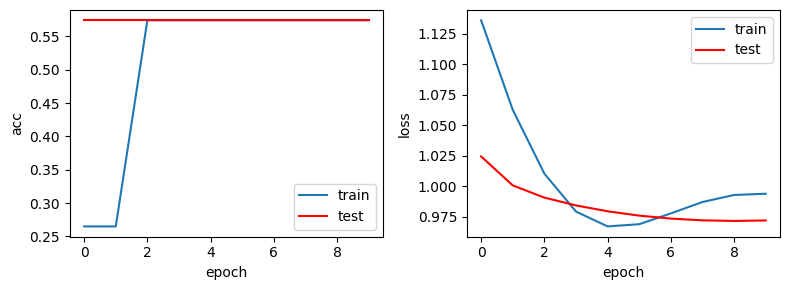

In [9]:
# 模型初始化
lr = 0.01
epochs = 10
net = MyConvModule().to(device)  
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(net.parameters(),lr = lr)   
train_loss_list = []  
train_acc_list = []  
test_loss_list = []  
test_acc_list = []
timestart = time.time() 
for epoch in range(epochs):  
    print('Epoch %d: '%(epoch+1), end="")
    train_loss, train_acc = trainmodel(net, train_loader)
    print('train: loss %.6f acc %.6f; '%(train_loss, train_acc), end="") 
    test_loss, test_acc = testmodel(net, test_loader)  
    print('test: loss %.6f, acc %.6f'%(test_loss, test_acc))
    train_loss_list.append(train_loss)  
    train_acc_list.append(train_acc )  
    test_loss_list.append(test_loss)  
    test_acc_list.append(test_acc)      
spendtime = (time.time() - timestart)  
print('Spend time: %.3f'%(spendtime)) 
draw(train_acc_list, test_acc_list, train_loss_list, test_loss_list)
del net  # 删除对模型
torch.cuda.empty_cache()  # 释放显存

In [10]:
# pytorch实现二维卷积
class ConvModule3(nn.Module):  
    def __init__(self):  
        super(ConvModule3,self).__init__()  
        # 三层卷积层  
        self.conv = nn.Sequential(  
            nn.Conv2d(in_channels = 3,out_channels = 32, kernel_size = 3 , stride = 1,padding=0), nn.BatchNorm2d(32), nn.ReLU(inplace=True),  
            nn.Conv2d(in_channels = 32,out_channels = 64, kernel_size = 3 , stride = 1,padding=0), nn.BatchNorm2d(64), nn.ReLU(inplace=True),  
            nn.Conv2d(in_channels = 64,out_channels = 128, kernel_size = 3 , stride = 1,padding=0), nn.BatchNorm2d(128), nn.ReLU(inplace=True)  )  
        # 输出层,将通道数变为分类数量  
        self.fc = nn.Linear(128, 3)  
    def forward(self,x):  
        # 图片经过三层卷积，输出维度变为(batch_size,C_out,H,W)  
        out = self.conv(x)  
        # 使用平均池化层将图片的大小变为 1 x 1
        out = nn.functional.avg_pool2d(out, 58)  
        # 将张量out从shape batch x 128 x 1 x 1 变为 batch x 128  
        out = out.squeeze()  
        # 输入到全连接层将输出的维度变为3  
        out = self.fc(out)  
        return out 
    def __str__(self):
        return "ConvModule3"

In [11]:
# 增加到四层卷积
class ConvModule4(nn.Module):  
    def __init__(self):  
        super(ConvModule4,self).__init__()  
        self.conv = nn.Sequential(  
            nn.Conv2d(in_channels = 3,out_channels = 32, kernel_size = 3 , stride = 1,padding=0), nn.BatchNorm2d(32), nn.ReLU(inplace=True),  
            nn.Conv2d(in_channels = 32,out_channels = 64, kernel_size = 3 , stride = 1,padding=0), nn.BatchNorm2d(64), nn.ReLU(inplace=True),  
            nn.Conv2d(in_channels = 64,out_channels = 128, kernel_size = 3 , stride = 1,padding=0), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 128,out_channels = 256, kernel_size = 3 , stride = 1,padding=0), nn.BatchNorm2d(256), nn.ReLU(inplace=True)
        )  
        # 输出层,将通道数变为分类数量  
        self.fc = nn.Linear(256, 3)  
    def forward(self,x):  
        out = self.conv(x)  
        out = nn.functional.avg_pool2d(out,54)  
        out = out.squeeze()   
        out = self.fc(out)  
        return out 
    def __str__(self):
        return "ConvModule4"

In [12]:
# 降低数据集batchsize,pytorch的计算方式显存占用更高
batch_size = 128
train_dataset = torchvision.datasets.ImageFolder(root = os.path.join(os.getcwd(), "cardata/train"), transform = data_transform["train"])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle = True, num_workers = 8)
test_dataset = torchvision.datasets.ImageFolder(root = os.path.join(os.getcwd(), "cardata/test"), transform = data_transform["test"])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False, num_workers = 8)

ConvModule3
Epoch 1: train: loss 0.791963 acc 0.665358; test: loss 1.125750, acc 0.674556
Epoch 2: train: loss 0.557433 acc 0.813543; test: loss 0.920565, acc 0.692308
Epoch 3: train: loss 0.512164 acc 0.829244; test: loss 0.680437, acc 0.772189
Epoch 4: train: loss 0.483293 acc 0.842002; test: loss 0.811068, acc 0.757396
Epoch 5: train: loss 0.481424 acc 0.844946; test: loss 0.576475, acc 0.801775
Epoch 6: train: loss 0.455089 acc 0.847890; test: loss 0.747889, acc 0.754438
Epoch 7: train: loss 0.449247 acc 0.849853; test: loss 0.584279, acc 0.798817
Epoch 8: train: loss 0.432907 acc 0.853778; test: loss 0.743845, acc 0.763314
Epoch 9: train: loss 0.448366 acc 0.835132; test: loss 0.547765, acc 0.813609
Epoch 10: train: loss 0.426136 acc 0.858685; test: loss 0.494883, acc 0.822485
Epoch 11: train: loss 0.405717 acc 0.850834; test: loss 0.467762, acc 0.813609
Epoch 12: train: loss 0.378786 acc 0.868499; test: loss 0.484907, acc 0.819527
Epoch 13: train: loss 0.363397 acc 0.868499; test

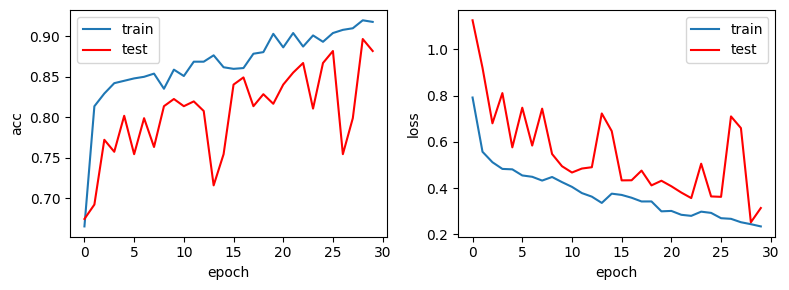

ConvModule4
Epoch 1: train: loss 0.771273 acc 0.684985; test: loss 3.117591, acc 0.355030
Epoch 2: train: loss 0.575402 acc 0.779195; test: loss 0.953021, acc 0.742604
Epoch 3: train: loss 0.486858 acc 0.825319; test: loss 0.629595, acc 0.784024
Epoch 4: train: loss 0.471767 acc 0.833170; test: loss 0.547630, acc 0.819527
Epoch 5: train: loss 0.425425 acc 0.853778; test: loss 0.589299, acc 0.798817
Epoch 6: train: loss 0.423383 acc 0.850834; test: loss 0.482943, acc 0.834320
Epoch 7: train: loss 0.420686 acc 0.854760; test: loss 0.601308, acc 0.763314
Epoch 8: train: loss 0.407041 acc 0.849853; test: loss 0.619999, acc 0.798817
Epoch 9: train: loss 0.385297 acc 0.863592; test: loss 0.442797, acc 0.813609
Epoch 10: train: loss 0.356045 acc 0.871443; test: loss 0.512549, acc 0.798817
Epoch 11: train: loss 0.355923 acc 0.876349; test: loss 0.843912, acc 0.757396
Epoch 12: train: loss 0.391786 acc 0.852797; test: loss 0.887243, acc 0.748521
Epoch 13: train: loss 0.365813 acc 0.877331; test

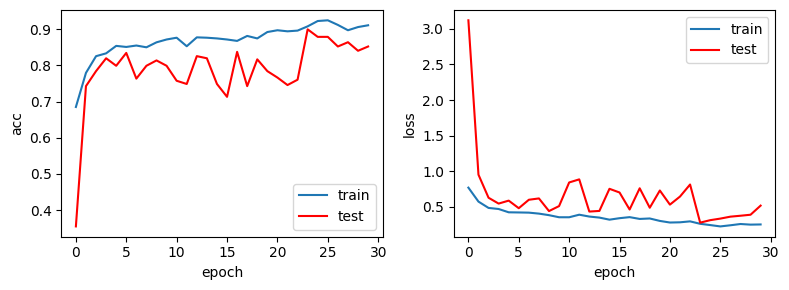

In [14]:
epochs = 30
netlist = [ConvModule3().to(device), ConvModule4().to(device)] 
for net in netlist:
    print(net)
    optimizer = torch.optim.Adam(net.parameters(),lr = lr)   
    train_loss_list = []  
    train_acc_list = []  
    test_loss_list = []  
    test_acc_list = []   
    timestart = time.time()  
    for epoch in range(epochs):  
        print('Epoch %d: '%(epoch+1), end="")
        train_loss, train_acc = trainmodel(net, train_loader)
        print('train: loss %.6f acc %.6f; '%(train_loss, train_acc), end="") 
        test_loss, test_acc = testmodel(net, test_loader)  
        print('test: loss %.6f, acc %.6f'%(test_loss, test_acc))
        train_loss_list.append(train_loss)  
        train_acc_list.append(train_acc )  
        test_loss_list.append(test_loss)  
        test_acc_list.append(test_acc)    
    spendtime = (time.time() - timestart)  
    print('Spend time: %.3f'%(spendtime)) 
    draw(train_acc_list, test_acc_list, train_loss_list, test_loss_list)
    del net
    torch.cuda.empty_cache()

lr:  0.1
epoch 1: train:loss 1.583262 acc 0.486752; test:loss 23.040082, acc 0.573964
epoch 2: train:loss 0.771450 acc 0.699706; test:loss 5.434265, acc 0.573964
epoch 3: train:loss 0.681472 acc 0.718351; test:loss 4.198072, acc 0.573964
epoch 4: train:loss 0.580420 acc 0.753680; test:loss 1.233888, acc 0.662722
epoch 5: train:loss 0.539243 acc 0.785083; test:loss 0.989983, acc 0.730769
epoch 6: train:loss 0.516972 acc 0.791953; test:loss 0.687817, acc 0.760355
epoch 7: train:loss 0.490106 acc 0.811580; test:loss 0.828647, acc 0.742604
epoch 8: train:loss 0.516979 acc 0.808636; test:loss 0.648892, acc 0.784024
epoch 9: train:loss 0.490006 acc 0.819431; test:loss 0.801455, acc 0.745562
epoch 10: train:loss 0.458073 acc 0.830226; test:loss 0.650539, acc 0.757396
epoch 11: train:loss 0.445968 acc 0.835132; test:loss 0.632486, acc 0.792899
epoch 12: train:loss 0.437139 acc 0.843965; test:loss 0.536129, acc 0.786982
epoch 13: train:loss 0.435946 acc 0.833170; test:loss 0.766688, acc 0.74852

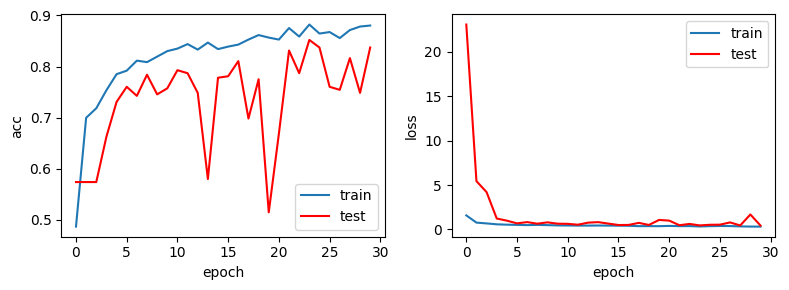

lr:  0.001
epoch 1: train:loss 0.796712 acc 0.675172; test:loss 0.972416, acc 0.508876
epoch 2: train:loss 0.592631 acc 0.808636; test:loss 0.901967, acc 0.446746
epoch 3: train:loss 0.536641 acc 0.824338; test:loss 0.872448, acc 0.526627
epoch 4: train:loss 0.501942 acc 0.843965; test:loss 0.769819, acc 0.621302
epoch 5: train:loss 0.463930 acc 0.854760; test:loss 0.563017, acc 0.775148
epoch 6: train:loss 0.431576 acc 0.860648; test:loss 0.515757, acc 0.789941
epoch 7: train:loss 0.415999 acc 0.863592; test:loss 0.475896, acc 0.834320
epoch 8: train:loss 0.386891 acc 0.871443; test:loss 0.452928, acc 0.816568
epoch 9: train:loss 0.375844 acc 0.865554; test:loss 0.487527, acc 0.801775
epoch 10: train:loss 0.377122 acc 0.868499; test:loss 0.414695, acc 0.846154
epoch 11: train:loss 0.348821 acc 0.877331; test:loss 0.411002, acc 0.828402
epoch 12: train:loss 0.330278 acc 0.882237; test:loss 0.353316, acc 0.840237
epoch 13: train:loss 0.322905 acc 0.881256; test:loss 0.350992, acc 0.8520

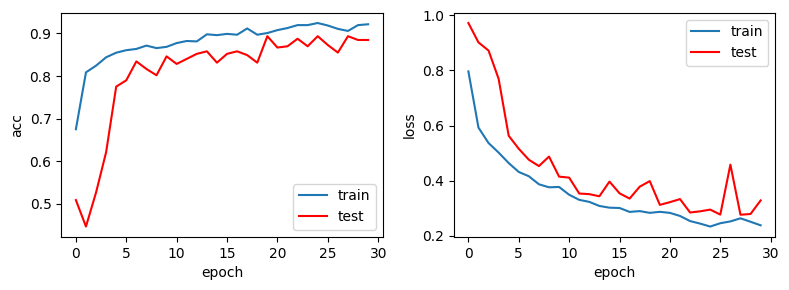

In [15]:
# 超参数对比分析
lr_list = [0.1, 0.001]
for lr in lr_list :
    print("lr: ",lr)
    net = ConvModule3().to(device) 
    optimizer = torch.optim.Adam(net.parameters(),lr = lr)
    train_loss_list = []  
    train_acc_list = []  
    test_loss_list = []  
    test_acc_list = []   
    timestart = time.time()  
    for epoch in range(epochs):  
        train_loss, train_acc = trainmodel(net, train_loader)  
        test_loss, test_acc = testmodel(net, test_loader)  
        train_loss_list.append(train_loss)  
        train_acc_list.append(train_acc )  
        test_loss_list.append(test_loss)  
        test_acc_list.append(test_acc)  
        print('epoch %d: train:loss %.6f acc %.6f; test:loss %.6f, acc %.6f'%(epoch+1, train_loss, train_acc, test_loss, test_acc)) 
    spendtime = (time.time() - timestart)  
    print('Spend time: %.3f'%(spendtime)) 
    draw(train_acc_list, test_acc_list, train_loss_list, test_loss_list)
    del net
    torch.cuda.empty_cache()